In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import spikeinterface as si
from dartsort.localize import localize_torch as loc

path_to_dataset = '/media/cat/data/noah/IBL_data_CEED/febb430e-2d50-4f83-87a0-b5ffbb9a4943/'
path2 = '/home/noah/code/CEED_new/CEED/notebooks/'

In [7]:
for root, dirs, files in os.walk(path_to_dataset):
    print(root)
    print(dirs)
    print(files)
    print('\n')

print('path2')
print('\n')

for root, dirs, files in os.walk(path2):
    print(root)
    print(dirs)
    print(files)
    print('\n') 

/media/cat/data/noah/IBL_data_CEED/febb430e-2d50-4f83-87a0-b5ffbb9a4943/
['properties', 'ds']
['_spikeglx_ephysData_g0_t0.imec0.ap.normalized.meta', 'probe.json', 'si_folder.json', 'binary.json', 'traces_cached_seg0.raw', 'provenance.json']


/media/cat/data/noah/IBL_data_CEED/febb430e-2d50-4f83-87a0-b5ffbb9a4943/properties
[]
['offset_to_uV.npy', 'contact_vector.npy', 'inter_sample_shift.npy', 'group.npy', 'location.npy', 'gain_to_uV.npy']


/media/cat/data/noah/IBL_data_CEED/febb430e-2d50-4f83-87a0-b5ffbb9a4943/ds
['covariances']
['labels_train.npy', 'channel_num_train.npy', 'labels_test.npy', 'spikes_val.npy', 'labels_val.npy', 'spikes_test.npy', 'channel_num_val.npy', 'channel_num_test.npy', 'channel_spike_locs_val.npy', 'channel_spike_locs_test.npy', 'spikes_train.npy', 'channel_spike_locs_train.npy']


/media/cat/data/noah/IBL_data_CEED/febb430e-2d50-4f83-87a0-b5ffbb9a4943/ds/covariances
[]
['temporal_cov.npy', 'spatial_cov.npy']


path2


/home/noah/code/CEED_new/CEED/notebooks/

In [4]:
# alternate data

# spikes_train = np.load(path_to_dataset + 'ds/' + 'spikes_train.npy')
# spikes_test = np.load(path_to_dataset + 'ds/' + 'spikes_test.npy')
# spikes_val = np.load(path_to_dataset + 'ds/' + 'spikes_val.npy')
# spikes = np.concatenate((spikes_train, spikes_test, spikes_val)) #not enough spikes!

# spikes.shape

In [5]:
#load recording
pathREC = r'/media/cat/data/noah/IBL_data_CEED/febb430e-2d50-4f83-87a0-b5ffbb9a4943/' #session 2
rec = si.read_binary_folder(pathREC)

In [8]:
geom = np.load(path2 + 'geom_sess2.npy')
templates = np.load(path2 + 'templates_sess2.npy')
spikes_idx = np.load(path2 + 'spike_idx_sess2.npy') #spike time, channel location of max channel, neuron id from spike sorting; for each spike
chans_idx = np.load(path2 + 'chan_idx_sess2.npy')

In [38]:
len(np.unique(spikes_idx[2]))

429

In [10]:
# spikes_val = np.load(path_to_dataset + 'ds/' + 'spikes_val.npy')
# spikes_train = np.load(path_to_dataset + 'ds/' + 'spikes_train.npy')
# spikes_test = np.load(path_to_dataset + 'ds/' + 'spikes_test.npy')
# spikes = np.concatenate((spikes_val, spikes_test, spikes_train)) #not enough spikes!


In [11]:
# print(spikes.shape)
# print(spikes_idx.shape)

In [114]:
#get amplitudes vector
amplitudes = rec.get_traces()[spikes_idx[0]] #use spike times as index to grab spikes amplitudes
print(amplitudes.shape) #spikes, channels. max amplitude of each spike on each channel

(159564, 384)


In [115]:
positions = spikes_idx[0]

spike_samples = []
for posit in positions:
    spike_samples.append(list(range(posit-43,posit+78)))
spike_samples = [item for sublist in spike_samples for item in sublist] 

# channels = spikes_idx[1]
# waveforms = rec.get_traces()[spikes_idx[0]][spikes_idx[1]]

In [116]:
#these two cells could be done in the same loop...

channel_indexs = spikes_idx[1] #need to extend each entry by 121 samples to match shape
channels_extended = []
for chan in channel_indexs:
    channels_extended.append([chan]*121)
channels_extended = [item for sublist in channels_extended for item in sublist]
    


In [117]:
waveforms = rec.get_traces()[spike_samples, channels_extended] #this is just the zero channel, need to take the best channel!!!!
#this finally works

In [118]:
print(waveforms.shape)
# reshape waveform array
waveforms = waveforms.reshape((159_564, 121))
print(waveforms.shape)

(19307244,)
(159564, 121)


In [17]:
# print(len(waveforms)/121)

In [18]:
# n=12000
# wave = waveforms[121*n:121*(n+1)]
# print(wave.shape)
# plt.plot(wave)
# plt.show()

In [19]:
#this method was way too memory intensive!!

#get waveforms
# 121 samples around the max amplitude
# # waveforms = np.empty((amplitudes.shape[0], 121, amplitudes.shape[1]))
# number_of_waves = 500
# waveforms = []
# for i, spike in enumerate(spikes_idx[0][0:number_of_waves]):
#     waveform = rec.get_traces()[spike-43:spike+78][:,spikes_idx[1][i]] #centre max peak of spike at sample 42
#     # waveforms[i] = rec.get_traces()[spike-42:spike+79]
#     waveforms.append(waveform)
# waveforms = np.asarray(waveforms)

42
(159564, 121)


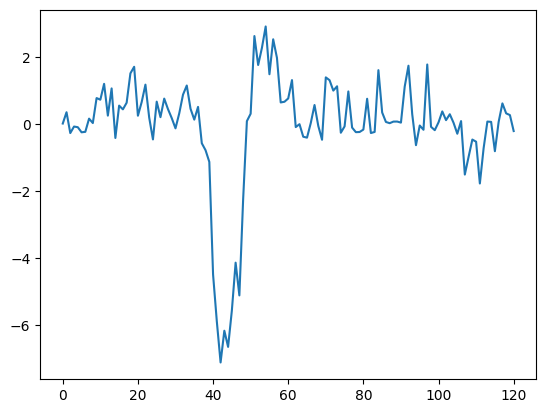

In [20]:
wave_no = 90
print(np.argmax(np.abs(waveforms[wave_no]))) #should be at 42
print(waveforms.shape) #waves should have length of 121
plt.plot(waveforms[wave_no])
plt.show()


In [21]:
radius = 100 #microns #100 correct
num_spikes_st = 0
num_spikes = -1
main_chan = spikes_idx[1]
subset = None
locs = loc.localize_amplitude_vectors(amplitude_vectors = amplitudes[0:num_spikes], n_channels_subset = subset, geom = geom, main_channels = main_chan[0:num_spikes], radius = radius)


In [120]:
z = locs["z_abs"]
x = locs["x"]
pitch = 40

idx_good = np.flatnonzero(np.logical_and(
    np.logical_and(x > geom[:, 0].min()-pitch, x < geom[:, 0].max()+pitch),
    np.logical_and(z > geom.min()-pitch, z < geom.max()+pitch)))

x = x[idx_good]
z = z[idx_good]
index = spikes_idx[2][idx_good]
waveforms = waveforms[idx_good, :]
amplitudes = amplitudes[idx_good, :]

In [121]:
print(waveforms.shape)
print(amplitudes.shape)

(158167, 121)
(158167, 384)


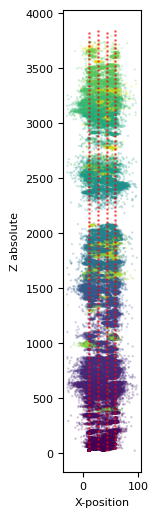

In [138]:
plt.figure(figsize=(1,6)) #2,12 is better tbh

plt.scatter(x, z, alpha=0.2, s = 0.5, c = index) #coloured by neuron id, adds nothing but confirms things work!
plt.scatter(geom[:,0], geom[:,1], c='red', alpha=0.5, s=0.9)
plt.xlabel('X-position')
plt.ylabel('Z absolute')
#2x12
plt.show()

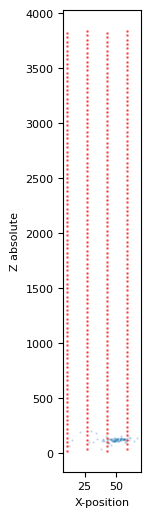

In [90]:
# spikes from one neuron, pretty good :)
neuronID = 5

x1 = x[index==neuronID]
z1 = z[index==neuronID]

plt.figure(figsize=(1,6)) #2,12 is better tbh

plt.scatter(x1, z1, alpha=0.2, s = 0.5) #coloured by neuron id, adds nothing but confirms things work!
plt.scatter(geom[:,0], geom[:,1], c='red', alpha=0.5, s=0.9)
plt.xlabel('X-position')
plt.ylabel('Z absolute')
#2x12
plt.show()

Whats with the x-direction smudge? Doesn't happen in z direction

# Make a useful dataset

In [24]:
#generating a single cell dataset with firing rate and predicting max fr from ceed embeddings.
import pandas as pd

In [25]:
single_cell_dataset = {spike_id: spike_id, spike_centre_waveform: spike_data, cluster: cluster_index, geometry: geo, channel_channelID}
#something liek this...

SyntaxError: ':' expected after dictionary key (926820734.py, line 1)

# CEED time

In [26]:
from ceed.models.ceed import CEED
import numpy as np
import os
import matplotlib.pyplot as plt
from analysis.projections import learn_manifold_umap, pca_train, pca
import colorcet as cc
import torch

from tqdm import tqdm

from mpl_toolkits.mplot3d import Axes3D

2023-11-08 18:48:10.825085: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-08 18:48:10.825119: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-08 18:48:10.825141: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-08 18:48:10.831910: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-08 18:48:12.295086: W tensorflow/compiler/

In [27]:
fc_celltype_ckpt_dir = '/home/noah/code/400neur_200s_5d_celltype_fc_ckpt/'

fc_celltype_ceed_5d = CEED(num_extra_chans=0, out_dim=5, proj_dim=5, gpu=0, old_ckpt=True)
fc_celltype_ceed_5d.load(fc_celltype_ckpt_dir)

Using projector; batchnorm False with depth 3; hidden_dim=512
loading from previous checkpoint:  /home/noah/code/400neur_200s_5d_celltype_fc_ckpt/


In [113]:
print(waveforms.shape)
batch = 1
cells = waveforms.shape[0]
timepoints = waveforms.shape[1]

(158167,)


IndexError: tuple index out of range

In [29]:
#convert to tensor, batch data for gpu, and send to gpu
waveforms = torch.from_numpy(waveforms.astype('float32')) #must be float32?
waveforms = waveforms.reshape(batch, int(cells/batch), timepoints)
# waveforms = waveforms.to('cuda') 

#put on the gpu in the inference loop?
#https://discuss.pytorch.org/t/dataset-location-runtimeerror-caught-runtimeerror-in-dataloader-worker-process-0/156842

print(waveforms.shape, waveforms.device)

torch.Size([1, 158167, 121]) cpu


In [60]:
idx_good

array([     0,      1,      2, ..., 159560, 159561, 159562])

In [61]:
embeddings_all = []
with torch.no_grad():
    for spike in tqdm(waveforms):
        # data = torch.unsqueeze(spike, dim=-1)
        spike.to('cuda')
        feature = fc_celltype_ceed_5d.transform(spike) #returns a np array
        embeddings_all.append(feature)
# embeddings_all = torch.concatenate(embeddings_all).to('cpu').detach().squeeze().numpy()
embeddings_all = np.asarray(embeddings_all).squeeze()

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.75s/it]


In [62]:
embeddings_all.shape

(158167, 5)

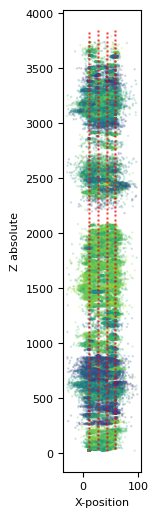

In [32]:
# plt.figure(figsize=(1,6)) #2,12 is better tbh

# plt.scatter(x, z, alpha=0.2, s = 0.5, c = embeddings_all[:,0]) #coloured by neuron id, adds nothing but confirms things work!
# plt.scatter(geom[:,0], geom[:,1], c='red', alpha=0.5, s=0.9)
# plt.xlabel('X-position')
# plt.ylabel('Z absolute')
# #2x12
# plt.show()

array([False, False, False, ..., False, False, False])

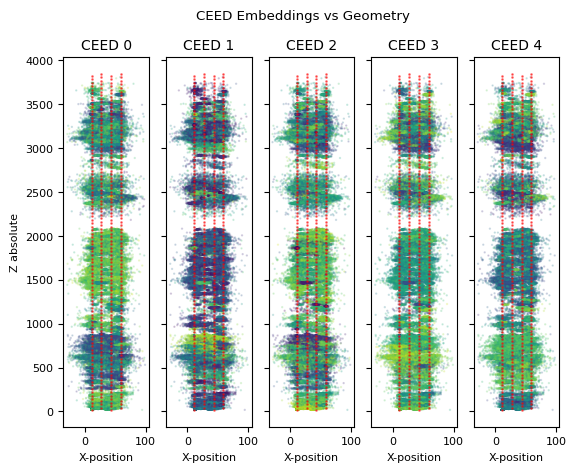

In [76]:
def qplot(i):
    ax[i].scatter(x, z, alpha=0.2, s = 0.5, c = embeddings_all[:,i])
    ax[i].scatter(geom[:,0], geom[:,1], c='red', alpha=0.5, s=0.9)
    ax[i].set_xlabel('X-position')
    if i == 0:
        ax[i].set_ylabel('Z absolute')
    title = 'CEED ' + str(i)
    ax[i].set_title(title)

fig, ax = plt.subplots(1,5, sharey = True)
fig.suptitle('CEED Embeddings vs Geometry', fontsize='large')

for i in range(5):
    qplot(i)

# fig.colorbar(ax[4], cax=embeddings_all[:,4])
# plt.colorbar(fig)
plt.show()


In [101]:
neuronID = 300
neuronID2 = 90

mask = np.logical_or(index==neuronID, index==neuronID2)

x1 = x[mask]

z1 = z[mask]

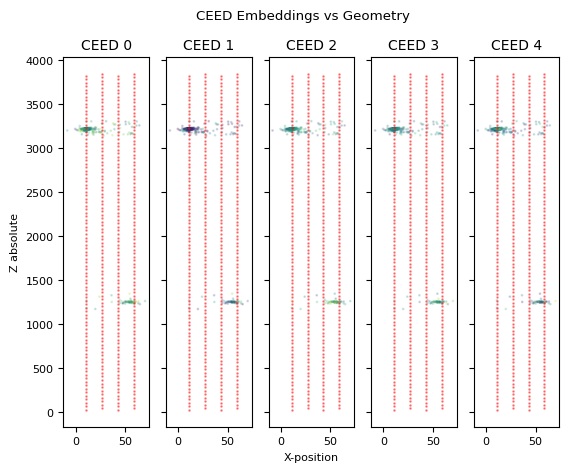

In [130]:
def qplot(i):
    ax[i].scatter(x1, z1, alpha=0.2, s = 0.9, c = embeddings_all[mask,i])
    ax[i].scatter(geom[:,0], geom[:,1], c='red', alpha=0.4, s=0.8)
    if i ==2:
        ax[i].set_xlabel('X-position')
    if i == 0:
        ax[i].set_ylabel('Z absolute')
    title = 'CEED ' + str(i)
    ax[i].set_title(title)


fig, ax = plt.subplots(1,5, sharey = True)
fig.suptitle('CEED Embeddings vs Geometry', fontsize='large')

for i in range(5):
    qplot(i)

# fig.colorbar(ax[4], cax=embeddings_all[:,4])
# plt.colorbar(fig)
plt.show()

#need to update colour map and add a colour bar

In [126]:
print(embeddings_all[neuronID])
print(embeddings_all[neuronID2])

[ 0.5333365  -0.73237103  0.08203124  0.33731243  0.24223119]
[ 0.01709404 -0.0028054  -0.8629769  -0.30210197 -0.40460497]


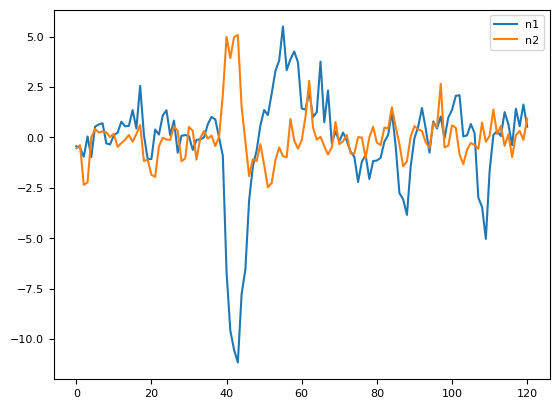

In [123]:
plt.plot(waveforms[neuronID], label='n1')
plt.plot(waveforms[neuronID2], label='n2')
plt.legend()
plt.show()

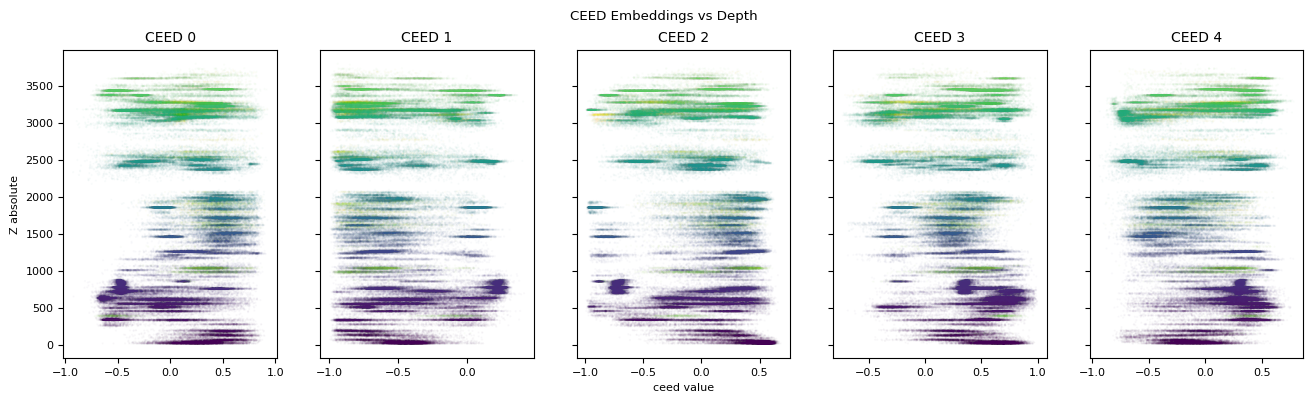

In [145]:
def qplot2(i):
    ax[i].scatter(embeddings_all[:,i], z, alpha=0.02, s = 0.5, c = index)
    if i ==2:
        ax[i].set_xlabel('ceed value')
    if i == 0:
        ax[i].set_ylabel('Z absolute')
    title = 'CEED ' + str(i)
    ax[i].set_title(title)
    

fig, ax = plt.subplots(1,5, sharey = True, figsize=(16, 4))
fig.suptitle('CEED Embeddings vs Depth', fontsize='large')

for i in range(5):
    qplot2(i)

# fig.colorbar(ax[4], cax=embeddings_all[:,4])
# plt.colorbar(fig)
plt.show()

In [ ]:
channels_ = spikes_maybe[1]

In [ ]:
#single channel, would be great to have multi channel

In [ ]:
spikes_maybe #spike times, channel location of max channl, neuron id form spike sortin

In [ ]:
#

In [ ]:
print(chans.shape)
print(channel_num.shape)
print(spike_locs.shape)
print(spikes.shape)
print(geom.shape)
print(templates.shape)
print(spikes_maybe.shape)

In [ ]:
amp_vecs = np.max(templates, axis=1)
amp_vecs.shape

In [ ]:
channel_num[90]

In [ ]:
spike_locs.shape #unit, channel, geometric_location

In [ ]:
spike_locs[0] #x, depth

print(np.max(spike_locs[:2000,0,0]) - np.min(spike_locs[:2000,0,0])) #

In [ ]:
# plt.scatter(spike_locs[:,0,0], spike_locs[:,0,1],)
# plt.show()

In [ ]:
# plt.plot(spike_locs[:2000,0,0])

In [ ]:
geom.shape

In [ ]:
# plt.scatter(geom[:,1], geom[:,0])

In [ ]:
# geom[:,0]

In [ ]:
# looking at spikes

spikes.shape #template, channel, time

In [ ]:
plt.plot(spikes[9040,0,:])
plt.show()

In [ ]:
# fig, axs = plt.subplots(1,2, figsize=(12,4))
spikes_ = spikes[labels==6,10,:].T #why transpose??
print(spikes_.shape)
axs[0].plot(np.mean(spikes_,1))

axs[1].plot(spikes_[:,10])
plt.show() #why is the 10th channel always the best??

In [ ]:
mask = [labels == 4]
mask = [labels == 3]
mask

In [ ]:
groups = []
for label in np.unique(labels):
    mask = labels == label
    spike_group = np.asarray(spikes)[mask]
    groups.append(spike_group)
plt.plot(np.mean(spike_group[:,10,:],axis =0))
plt.show()


# spikes_ = spikes[labels==4,8,:].T #why transpose??
# spike_group.shape

In [ ]:
groups[0].shape 

#what channel should be used! channel id!! :)

In [ ]:
plt.plot(groups[1][9][15])
plt.show()

In [ ]:
templates.shape

In [ ]:
plt.plot(templates[7,:,0:33])#32 seems to be last channel with any signal
plt.show()

In [ ]:
#actual spike data looks terrible

#actual spikes
unq_labels = np.unique(labels)
means = np.empty((len(unq_labels), 121))
for i, label in enumerate(unq_labels):
    mask = np.array([labels == label]).flatten()
    spikes_label = spikes[:,3,:][mask] #channel could be ther problem here... need to fix that
    mean = np.mean(spikes_label, axis=0)
    means[i] = mean


In [ ]:
plt.plot(spikes_label[0])

In [ ]:
plt.plot(means[167])
plt.show()

In [ ]:
plt.plot(np.mean(spikes[spikes[labels==3,8,:]

In [ ]:
#ceed embedding performance in cell typeing and spike sorting compared to baseline

# TODO:

firing rate, depth, geometry of indiviudal spikes compared to templates, coloured by ceed embeddings
max firing rate is a proxy for cell types - interneurons fire far faster than exitatory

try a ps-vae?

localisation code

In [ ]:
#generating a single cell dataset with firing rate and predicting max fr from ceed embeddings.
import pandas as pd

In [ ]:
single_cell_dataset = {spike_id: spike_id, spike_centre_waveform: spike_data, cluster: cluster_index, geometry: geo, channel_channelID}





In [ ]:
amplitudes.argmax(axis =1)
print(amplitudes.shape)
print(geom.shape)

In [ ]:
np.isnan(amplitudes).any()

In [ ]:
np.min(amplitudes)

In [ ]:
main_chan = np.abs(amplitudes).argmax(axis=1)
main_chan = spikes_maybe[1]

In [ ]:
radius = 50 #microns #100 correct
num_spikes_st = 0
num_spikes = -1
# main_chan = np.ones(len(amplitudes))*10 #this is bad
# main_chan = amplitudes.argmax(axis =1)
subset = None
locs = loc.localize_amplitude_vectors(amplitude_vectors = amplitudes[0:num_spikes], n_channels_subset = subset, geom = geom, main_channels = main_chan[0:num_spikes], radius = radius)



In [ ]:
z = locs['z_abs']
x = locs["x"]

In [ ]:
locs.keys()

In [ ]:
pitch = 40

idx_good = np.flatnonzero(np.logical_and(
    np.logical_and(x > geom[:, 0].min()-pitch, x < geom[:, 0].max()+pitch),
    np.logical_and(z > geom.min()-pitch, z < geom.max()+pitch)))

x = x[idx_good]
z = z[idx_good]
# z_reg = z_reg[idx_good]
# maxptps = maxptps[idx_good]
# spt = spt[idx_good]

In [ ]:
plt.figure(figsize=(2,12))

plt.scatter(x, z, alpha=0.3, s = 0.7)
plt.scatter(geom[:,0], geom[:,1], c='red', alpha=0.5, s=0.9)
#2x12
plt.show()

In [ ]:
#colour code polts by ceed features

In [ ]:
#depth by ceed plot

In [ ]:
from ceed.models.ceed import CEED
import numpy as np
import os
import matplotlib.pyplot as plt
from analysis.projections import learn_manifold_umap, pca_train, pca
import colorcet as cc
import torch

from mpl_toolkits.mplot3d import Axes3D

In [ ]:
fc_celltype_ckpt_dir = '/home/noah/code/400neur_200s_5d_celltype_fc_ckpt/'

fc_celltype_ceed_5d = CEED(num_extra_chans=0, out_dim=5, proj_dim=5, gpu=0, old_ckpt=True)
fc_celltype_ceed_5d.load(fc_celltype_ckpt_dir)

In [ ]:
# help(CEED)

In [ ]:
#convert to tensor, batch data for gpu, and send to gpi
spikes_tensor = torch.from_numpy(spike_data.astype('float32')) #must be float32?
sample_data_tensor = sample_data_tensor.reshape(batch, int(cells/batch), timepoints)
sample_data_tensor = sample_data_tensor.to('cuda')
print(sample_data_tensor.shape, sample_data_tensor.device)

In [ ]:
#waveforms:

wavs = rec.get_traces()

In [ ]:
wavs[0].shape

In [ ]:
spikes_maybe[0]

In [ ]:
# checkpoint_path = '/home/noah/code/400neur_200s_5d_celltype_fc_ckpt'

# # fc_celltype_ckpt_dir = '/media/cat/data/CEED_celltype/400neur_200s_5d_celltype_fc_ckpt/'

# fc_celltype_ceed_5d = CEED(num_extra_chans=0, out_dim=5, proj_dim=5)
# fc_celltype_ceed_5d.load(fc_celltype_ckpt_dir)#this is for transformer model!

In [ ]:
# start running some inference:




In [ ]:
templates.shape

In [ ]:
chans.shape

In [ ]:
geom.shape

In [ ]:
amplitude_vecotors = #shape is number of spikes and number of channels it was recorded on

In [ ]:
chans.shape

In [ ]:
spike_locs[0]

In [ ]:
channel_num.shape #amp_vector

In [ ]:
#convert templates to amplitude vectors


In [ ]:
#ceed embed these, cluster, then plot cluster with location

# TODO 3rd nov:

PSVAE with handpicked features, also try to find the most linear way to go from embeddings to waveform (PCA)
Try to predict the multichannel waveform from just the single channel embedding with spatial location 

try to predict spatial location from waveform (depth). CEED embeddings and depth

### also, look at optotagging with neuropixel for cell typing
### keep thinking about 2p with neuropixel